# Text classification with LSTMs

## Table of contents
- [Imports](#im)
- [1: Data and baseline](#1)
- [2: Preparing the data for LSTMs](#2) 
- [3: Defining LSTM network architecture](#3) 
- [4: Training and evaluation](#4) 

### Imports <a name="im"></a>

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

pd.set_option("display.max_colwidth", 0)

## Introduction 
<hr>

Variants of recurrent neural networks such as long short-term memory networks (LSTMs) are one of the most popular models in natural language processing. But training them using deep learning libraries such as `PyTorch` is quite an involved process. In this lab, my intention is to familiarize you with the steps involved in training LSTMs for text classification using `PyTorch` and `torchtext`. Since we have not used `torchtext` much before, this lab has a tutorial-like format, where most of the code is given to you. 

In [3]:
# You will need to upload your downloaded datafile to Google drive and mount the drive as follows.
# Read files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls "/content/gdrive/MyDrive/data"

cleaned_hm.csv	test.csv  train.csv  valid.csv


In [5]:
!pwd

/content


In [ ]:
#pd.read_csv('gdrive/MyDrive/data/train.csv')

<br><br>

## 1: Data and baseline <a name="1"></a>
<hr>

We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available. 

**To do:**
- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.
- Create a folder called `data` in your lab directory. 

For `torchtext`, we need train, valid, and test CSVs in a folder. Below I am providing some starter code to 

- read the data CSV (assuming it's saved as `cleaned_hm.csv` in your current directory)
- split the data into train, valid, and test portions
- write `train.csv`, `valid.csv`, and `test.csv` files in the `data` directory you have created above

In [6]:
#df = pd.read_csv("cleaned_hm.csv", index_col=0)
df = pd.read_csv('gdrive/MyDrive/data/cleaned_hm.csv',index_col=0)
df.head(10)

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27673,2053,24h,I went on a successful date with someone I felt sympathy and connection with.,I went on a successful date with someone I felt sympathy and connection with.,True,1,NaN,affection
27674,2,24h,I was happy when my son got 90% marks in his examination,I was happy when my son got 90% marks in his examination,True,1,NaN,affection
27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27677,6227,24h,I went with grandchildren to butterfly display at Crohn Conservatory\r\n,I went with grandchildren to butterfly display at Crohn Conservatory\r\n,True,1,NaN,affection
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27679,195,24h,"I made a new recipe for peasant bread, and it came out spectacular!","I made a new recipe for peasant bread, and it came out spectacular!",True,1,NaN,achievement
27680,740,24h,I got gift from my elder brother which was really surprising me,I got gift from my elder brother which was really surprising me,True,1,NaN,affection
27681,3,24h,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,True,1,NaN,enjoy_the_moment


In [7]:
df["ground_truth_category"].value_counts()

affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature              252 
exercise            217 
Name: ground_truth_category, dtype: int64

In [8]:
sample_df = df.dropna()
sample_df.shape

(14125, 8)

In [9]:
sample_df["ground_truth_category"].value_counts()

affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature              252 
exercise            217 
Name: ground_truth_category, dtype: int64

In [10]:
sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "label"}, inplace=True
)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
big_train_df, test_df = train_test_split(sample_df, test_size=0.1, random_state=123)

In [13]:
train_df, valid_df = train_test_split(big_train_df, test_size=0.2, random_state=123)

In [14]:
cols = ["moment", "label"]

In [15]:
#train_df.to_csv("data/train.csv", columns=cols, index=False)
#valid_df.to_csv("data/valid.csv", columns=cols, index=False)
#test_df.to_csv("data/test.csv", columns=cols, index=False)

You should now have `train.csv`, `valid.csv`, and `test.csv` files written under the `data` folder. 

<br><br>

### 1.1 Baselines 

So far we have been carrying out text classification with bag-of-words (`CountVectorizer`) features and traditional machine learning models such as logistic regression and SVMs, which are not capable of dealing with sequential data. Bag-of-words representation does not take ordering of the words into account. For instance, with bag-of-words representation, S1 and S2 below would have the same interpretation. 

> S1: The movie was not bad. It was good. 

> S2: The movie was bad. It was not good. 

One of the primary advantages of an RNN is that it takes into account ordering of the words and sequential information available in text. That said, text classification models with bag-of-words representation are fast to implement and train and easy to understand, and in many cases they are good enough for the given task. So let's examine how well these models are performing on our task so that later we will be able to check whether we are gaining anything with RNNs or not.  

1. Implement `DummyClassifier` baseline. Report cross-validation scores. 
2. Implement `LogisticRegression` with bag-of-words representation (`CountVectorizer`). Report cross-validation scores. 

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

X_train, y_train = big_train_df["moment"], big_train_df["label"]
X_test, y_test = test_df["moment"], test_df["label"]
scoring = ["accuracy"]
results = {}
dummy = DummyClassifier(strategy='stratified')
scores = cross_validate(dummy, X_train, y_train, return_train_score=True, scoring = scoring)
results["dummy"] = pd.DataFrame(scores).mean()
pd.DataFrame(results)

,dummy
fit_time,0.006146
score_time,0.002984
test_accuracy,0.245202
train_accuracy,0.240482


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

text_transformer = make_pipeline(CountVectorizer(max_features=20_000))

pipe = make_pipeline(text_transformer, LogisticRegression(class_weight="balanced"))
scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=scoring)
results["Logistic Regression"] = pd.DataFrame(scores).mean()
#warnings.filterwarnings("ignore"s)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [20]:
pd.DataFrame(results)

,dummy,Logistic Regression
fit_time,0.006146,2.715815
score_time,0.002984,0.088651
test_accuracy,0.245202,0.817417
train_accuracy,0.240482,0.951031


## 2: Preparing the data for LSTMs <a name="2"></a>
<hr>

A lot of the work in developing neural network models for text data goes into data preprocessing and getting the text into the suitable format. There are a number of steps involved in data preprocessing. 

- [ ] Data splitting (train, valid, test)
- [ ] Loading the data files
- [ ] Tokenization
- [ ] Creating a vocabulary: Creating a list of unique words 
- [ ] Numericalization: Converting text to a set of integers. 
- [ ] Word vectors
- [ ] Embedding lookup 
- [ ] Batching

We'll use the [`torchtext`](https://pypi.org/project/torchtext/) library to help us with some of these preprocessing steps. 


Install `torchtext` in your environment. 

```pip install torchtext```

> This lab assumes that you have `torchtext` version 0.9.0. 

In [21]:
import torchtext
from torchtext.legacy.data import (
    BucketIterator,
    Field,
    Iterator,
    LabelField,
    TabularDataset,
)

<br><br>

### 2.1 Tokenization and defining TEXT and LABEL

We'll use `spaCy` for tokenization and tell `PyTorch` how we want our text and label fields to be processed using `torchtext`'s [`Field`]((https://torchtext.readthedocs.io/en/latest/data.html?highlight=Field#field). The code below defines `TEXT` and `LABEL` using `torchtext`'s [`Field`](https://torchtext.readthedocs.io/en/latest/data.html?highlight=Field#field).  


In [22]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


def tokenize_spacy(text):
    """
    return tokenized text using spacy
    """
    # Solution_2_1_1
    ### YOUR ANSWER HERE
    return [word.text for word in nlp.tokenizer(text)]

In [23]:
tokenize_spacy("This is a test!")

['This', 'is', 'a', 'test', '!']

In [24]:
TEXT = Field(sequential=True, tokenize=tokenize_spacy, lower=True)
LABEL = Field(sequential=False, unk_token=None)

<br><br>

### 2.2 Load data 
We need to tell the declared fields above what data they should work with. Let's load the data with [`TabularDataset`](https://torchtext.readthedocs.io/en/latest/data.html?highlight=TabularDataset#tabulardataset).

In [25]:
fields = [("moment", TEXT), ("label", LABEL)]
train, valid, test = TabularDataset.splits(
    #path="./data/",  # the root directory where the data lies
    path="gdrive/MyDrive/data/",  # the root directory where the data lies
    train="train.csv",
    validation="valid.csv",
    test="test.csv",
    format="csv",
    skip_header=True,
    fields=fields,
)

> Here, we are retrieving the train, valid, and test data files that were created in Exercise 1.1. The columns to define those datasets are defined by `fields`. This is to allows us to perform tokenization of all the "moment" columns in all the files and preprocess given the labels from "label". The preprocess tabluar datasets are returned at the end, each in its own object.

### 2.3 Build and explore vocabulary
The next step is building vocabularies for TEXT and LABEL so that we can convert text into integer sequences. The code below builds vocabulary for `TEXT` with `glove.6B.100d` vectors and vocabulary for LABEL (integers associated with unique labels). 

In [26]:
TEXT.build_vocab(train, min_freq=3, vectors="glove.6B.100d")
LABEL.build_vocab(train)

print("Size of vocab: ", len(TEXT.vocab))
top_10_words = [(coup[0]) for coup in TEXT.vocab.freqs.most_common(10)]
print("10 Most common words of vocab: ", top_10_words)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 398552/400000 [00:15<00:00, 26113.34it/s]

Size of vocab:  3464
10 Most common words of vocab:  ['.', 'i', 'my', 'a', 'to', 'and', 'the', 'was', ',', 'for']


In [27]:
sents = [
    "my students will graduate soon!",
    "we are building a preprocessing pipeline for lstms.",
]

In [28]:
sent_1 = TEXT.preprocess(sents[0])
sent_2 = TEXT.preprocess(sents[1])

tensor = TEXT.process([sent_1, sent_2])
print(tensor)

tensor([[   4,   25],
        [ 684,   97],
        [ 153, 1005],
        [ 874,    5],
        [ 660,    0],
        [  55,    0],
        [   1,   11],
        [   1,    0],
        [   1,    2]])


> There are 3 unknown words, represented by 0 in the numerical tensor representation above.

### 2.4 train, valid, test iterators  
Now that we know how to numericalize data, the next step is padding and creating iterators for `train`, `valid`, and `test` splits. Below code
- creates these iterators with `sort = False` and `sort_within_batch=False`  arguments 
- shows first few padded examples from the first batch 

Create iterators `train_iter`, `valid_iter`, and `test_iter` using `BucketIterator.splits` with `sort=True` and `sort_within_batch=True` and examine the first batch. 

In [29]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(32, 32, 32),
    sort_key=lambda x: len(x.moment),
    sort=False,  # setting it to False to examine the batch.
    sort_within_batch=False,  # setting it to False to examine the batch.
)

In [30]:
for batch in train_iter:
    moments = batch.moment
    labels = batch.label
    break

In [31]:
moments.shape

torch.Size([94, 32])

In [32]:
def print_preprocessed_examples(moments, labels, n=4):
    print("preprocessed corpus:")
    df_data = defaultdict(list)
    for j in range(n):  # sample loop
        df_data["tokens"].append(
            [TEXT.vocab.itos[moments[i, j]] for i in range(moments.shape[0])]
        )
        df_data["example"].append(j)
        df_data["label"] = labels[j].item()
    return pd.DataFrame(df_data)

In [33]:
print_preprocessed_examples(moments, labels)

preprocessed corpus:


,tokens,example,label
0,"[i, met, my, sister, after, 15, years, of, not, seeing, each, other, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]",0,0
1,"[at, the, afternoon, ,, when, i, review, the, money, earned, in, my, mturk, <unk>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]",1,0
2,"[i, painted, my, home, last, month, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]",2,0
3,"[my, mother, came, to, visit, and, we, got, along, great, ., <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]",3,0


In [34]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(32, 32, 32),
    sort_key=lambda x: len(x.moment),
    sort=True,  # setting it to True to examine the batch.
    sort_within_batch=True,  # setting it to True to examine the batch.
)

In [35]:
for batch in train_iter:
    moments = batch.moment
    labels = batch.label
    break

In [36]:
moments.shape

torch.Size([3, 32])

In [37]:
print_preprocessed_examples(moments, labels)

preprocessed corpus:


,tokens,example,label
0,"[enjoy, with, friends]",0,3
1,"[enjoy, with, family]",1,3
2,"[i, went, movie]",2,3
3,"[night, shopping, event]",3,3


> When using `sort=True` and `sort_within_bath=True`, we are grouping examples of similar lengths together to ensure we are minimizing the padding, which is why it is the preferred approach.

### 2.5 Embedding lookup

Instead of one-hot representation of words, we will be feeding in 100-dimensional GloVe pre-trained embedding representation of words to the network.  

The code below creates embedding lookup table for all words in our vocabulary and gets embeddings for the `moments` object from the previous exercise. 

In [38]:
WORD_VEC_SIZE = 100
VOCAB_SIZE = len(TEXT.vocab)
VOCAB_SIZE

3464

In [39]:
embedding = nn.Embedding(VOCAB_SIZE, WORD_VEC_SIZE, sparse=True)
print("lookup table shape = ", embedding.weight.size())

lookup table shape =  torch.Size([3464, 100])


In [40]:
moments_embeddings = embedding(moments)

In [41]:
moments_embeddings.shape

torch.Size([3, 32, 100])

> The shape of `moments_embeddings` is [3, 32, 100]. The 3 corresponds to the number of sentences, followed by the 32 words in each and embeddings representation of size 100.

In [42]:
moments_embeddings[0, 0, :]

tensor([ 0.3702, -0.1596, -0.2809,  1.0452, -0.1587, -0.0889, -1.1730, -0.1050,
         0.1134,  0.0509, -0.8071,  1.1902,  0.1789, -0.4104,  0.2496, -0.7975,
         0.2241,  0.0599, -0.5650,  1.3956,  1.0549,  0.0928,  1.2104, -0.4676,
         0.5980, -0.6787,  0.1325, -0.1865,  0.5388, -0.9643, -0.8258, -1.4535,
         0.9183, -0.3783,  2.7459, -0.1653,  0.6637,  0.0303, -0.0471, -1.4707,
        -0.2160,  1.6368, -1.1374,  0.5581, -0.7656,  1.0078,  0.7132, -0.6409,
        -0.0882,  1.2613,  1.5378, -0.8134,  0.6688,  1.3540, -0.2638, -0.0259,
        -0.0537, -0.7988, -0.6717,  0.8704, -1.3674, -0.3977, -0.0617,  1.1158,
         1.2468, -1.7712, -1.5736, -0.4420, -1.6735,  0.7503,  0.2669, -1.2169,
         0.6866,  0.8340,  0.6806, -1.3048,  0.2233,  2.5756, -0.0092,  0.5507,
         1.1500, -0.5679, -0.1882,  0.2451,  0.2769, -1.7062,  0.6988, -0.8582,
        -0.5770, -0.2300,  0.4017, -0.8018, -0.4263,  0.3483,  0.0632, -0.5791,
         0.8394, -1.5801, -0.9189,  1.54

> It is a good idea to pass pre-trained word embeddings to the network in our task since the pretrained embedding were training on a large corpus which we consider is reliable enough. Creating our own embeddings on a smaller corpus is likely to be reliable and accurate. Also, it is quite expensive and time consuming to train word embeddings.

## 3: Defining LSTM network architecture <a name="3"></a>
<hr>

Now that we have preprocessed our data, we are now ready to define our network architecture. 

### 3.1 LSTMs 

In [43]:
class LSTMModel(nn.Module):
    def __init__(
        self, embedding_size, vocab_size, output_size, hidden_size, num_layers
    ):
        super(LSTMModel, self).__init__()
        # Solution_3_1_1
        ### YOUR ANSWER HERE

        # code adapted from demo
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_size
        )
        
        self.lstm_rnn = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.activation_fn = nn.ReLU()
        self.linear_layer = nn.Linear(hidden_size, output_size)
        self.softmax_layer = nn.LogSoftmax(dim=-1)


    def forward(self, x):
        # Solution_3_1_1
        ### YOUR ANSWER HERE
        out = self.embedding(x)
        out, (h_state, c_state) = self.lstm_rnn(
            out
        )
        # classify based on the hidden representation at the last token
        out = out[-1]
        out = self.activation_fn(out)
        out = self.linear_layer(out)
        out = self.softmax_layer(out)
        return out


> For my network architecture, I defined the following layers:
> - Embedding layer (`nn.Embedding`)
>   - This layer is responsible fort crearing lookup tables and initializing embeddings using inputs the same size of `TEXT` vocabulary. It can be used to obtain task-specific embeddings during the learning process.
> - LSTM layers (`nn.LSTM`)
>   - The number of LSTM layers is defined by `num_layers`.
>   - The layer takes input size, hidden size, and number of layers as inputs
> - An activation function layer for non linearity (`nn.Tanh`)
> - A linear layer (`nn.Linear`)
> - An output layer (`nn.LogSoftmax`)
>   - This layer acts on the outout of `nn.Linear` on top of the output of linear layer 

<br><br>

<br><br><br><br>

### Exercise 4: Training and evaluation <a name="4"></a>
<hr>

Now that we have defined our network architecture, we are ready to train our model. Let's first set the device. 

In [44]:
manual_seed = 123
torch.manual_seed(manual_seed)  # set the seed (for reproducibility)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

Given a data iterator, the `train` and `evaluate` functions below train and evaluate the model for all batches. 

In [45]:
from sklearn.metrics import accuracy_score


def train(dataloader):
    total_loss = 0.0
    # iterate throught the data loader
    num_samples = 0

    for batch in dataloader:
        # load the current batch
        batch_input = batch.moment
        batch_output = batch.label

        batch_input = batch_input.to(device)
        batch_output = batch_output.to(device)

        # forward pass
        model_outputs = model(batch_input)

        # compute the loss
        cur_loss = criterion(model_outputs, batch_output)
        total_loss += cur_loss.item()

        # backward propagation (compute the gradients and update the model)
        # clear the buffer
        optimizer.zero_grad()

        # compute the gradients
        cur_loss.backward()

        # update the weights
        optimizer.step()

        num_samples += batch_output.shape[0]

    return total_loss / num_samples

In [46]:
def evaluate(dataloader):
    preds = []
    labels = []
    with torch.no_grad():  # for efficiency
        for batch in dataloader:
            # load the current batch
            try:
                batch_input = batch.moment
                batch_output = batch.label
                batch_input = batch_input.to(device)
                batch_output = batch_output.to(device)
                # forward propagation
                model_outputs = model(batch_input)
                # identify the predicted class for each example in the batch
                probabilities, predicted = torch.max(model_outputs.cpu().data, 1)
                preds.extend(predicted.cpu())
                labels.extend(batch_output.cpu())
            except:
                print("Error calculating predictions")
                print(batch)
    accuracy = accuracy_score(preds, labels)
    return accuracy

### 4.1 Instantiating the model

Define hyperparameters of the model, instantiate the model using `LSTMModel`, examine the number of parameters of the model, and create a `checkpoint` directory to save models after each epoch.  

> For some pre-defined hyperparameters, I am using some standard values. Feel free to experiment with different values for the hyperparameters. 

In [1]:
HIDDEN_SIZE = 128  # number of units in the hidden layer
NUM_LAYERS = 2  # number of hidden layers
MAX_EPOCHS = 20  # number of passes over the training data
LEARNING_RATE = 0.2  # learning rate for the weight update rule
NUM_CLASSES = 7  # number of classes for the problem
EMBEDDING_SIZE = 100  # size of the word embedding

In [48]:
# Create a directory for writing models.
import os

CHECKPOINT_PATH = "gdrive/MyDrive/checkpoint"
if not os.path.exists(CHECKPOINT_PATH):
    os.mkdir(CHECKPOINT_PATH)

In [49]:
model = None

model = LSTMModel(
    EMBEDDING_SIZE, VOCAB_SIZE, NUM_CLASSES, HIDDEN_SIZE, NUM_LAYERS
)
print(model)

LSTMModel(
  (embedding): Embedding(3464, 100)
  (lstm_rnn): LSTM(100, 128, num_layers=2)
  (activation_fn): ReLU()
  (linear_layer): Linear(in_features=128, out_features=7, bias=True)
  (softmax_layer): LogSoftmax(dim=-1)
)


In [50]:
model.to(device)  # ship the  to the right device
criterion = nn.NLLLoss()  # define the loss function (last node of the network)

# Count the number of trianable parameters
def count_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [51]:
count_parameters(model)

597159

> The embedding layer input dimension is equivalent to the total vocabulary in the text. The output is an embeddings representation of the embedding size, defined as 100. The dimension of the linear layer is equal to the number of classes, defined as 7. There are 2  unidirectional LSTM layers defined by num_layers whose input is defined by num_class, input_sice, and hidden_size. As input, it takes the embedding size and outputs a dimension of size hidden_size, which is then fed into the linear layer. The activation layers have the same dimensions, taking the last hidden layer as input before feeding it to the linear layer. We pass the last hidden layer into an activation function before feeding it into a linear layer. The output of the softmax layer will be the same dimension as the number of classes since the layer gives the log probabilities of each class. There are 597159 trainable parameters.

<br><br>

### 4.2 Initializing the pretrained embeddings and carry out one forward pass

The code below initializes the `model` above with pre-trained GloVe embeddings. 

Run the code below to carry out one forward pass over a sample input batch (`moments` and `labels`) from 2.4 above and report the loss.  

In [52]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
print(pretrained_embeddings.shape)

torch.Size([3464, 100])


In [53]:
moments = moments.to(device)
labels = labels.to(device)

In [54]:
preds = model(moments)
loss = criterion(preds, labels)
print("loss = ", loss.item())

loss =  1.9304802417755127


<br><br>

### 4.3 Train the model

The code below trains the model for MAX_EPOCHS epochs.   

In [55]:
# create an instance of SGD with required hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

epochs, losses, train_accs, valid_accs = [], [], [], []

# Train the model
for epoch in range(MAX_EPOCHS):
    # train the model for one pass over the data
    train_loss = train(train_iter)
    losses.append(train_loss)

    # compute the training accuracy
    train_acc = evaluate(train_iter)
    train_accs.append(train_acc)

    # compute the validation accuracy
    valid_acc = evaluate(valid_iter)
    valid_accs.append(valid_acc)

    epochs.append(epoch + 1)

    # print the loss for every epoch
    print(
        "Epoch %d, Loss %0.4f, Train accuracy %0.4f; Validation accuracy %0.4f"
        % (epoch + 1, train_loss, train_acc, valid_acc)
    )

    # save model, optimizer, and number of epoch to a dictionary
    model_save = {
        "epoch": epoch,  # number of epoch
        "model_state_dict": model.state_dict(),  # model parameters
        "optimizer_state_dict": optimizer.state_dict(),  # save optimizer
        "loss": train_loss,  # training loss
    }
    torch.save(model_save, CHECKPOINT_PATH + "/model_{}.pt".format(epoch))

Epoch 1, Loss 0.0483, Train accuracy 0.3430; Validation accuracy 0.3417
Epoch 2, Loss 0.0403, Train accuracy 0.4457; Validation accuracy 0.4274
Epoch 3, Loss 0.0327, Train accuracy 0.4814; Validation accuracy 0.4632
Epoch 4, Loss 0.0291, Train accuracy 0.6238; Validation accuracy 0.6268
Epoch 5, Loss 0.0266, Train accuracy 0.3424; Validation accuracy 0.3417
Epoch 6, Loss 0.0224, Train accuracy 0.4690; Validation accuracy 0.4503
Epoch 7, Loss 0.0193, Train accuracy 0.4400; Validation accuracy 0.4310
Epoch 8, Loss 0.0176, Train accuracy 0.7350; Validation accuracy 0.7149
Epoch 9, Loss 0.0166, Train accuracy 0.6761; Validation accuracy 0.6606
Epoch 10, Loss 0.0159, Train accuracy 0.8041; Validation accuracy 0.7747
Epoch 11, Loss 0.0153, Train accuracy 0.8079; Validation accuracy 0.7790
Epoch 12, Loss 0.0145, Train accuracy 0.8131; Validation accuracy 0.7845
Epoch 13, Loss 0.0135, Train accuracy 0.8201; Validation accuracy 0.7924
Epoch 14, Loss 0.0125, Train accuracy 0.8661; Validation acc

Text(0.5, 1.0, 'Train Accuracy Cuve')

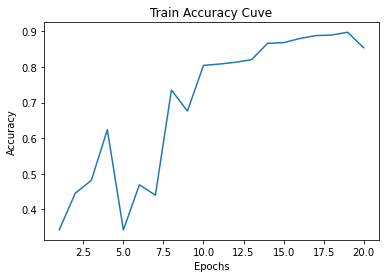

In [56]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_accs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Cuve")

Text(0.5, 1.0, 'Validation Accuracy Cuve')

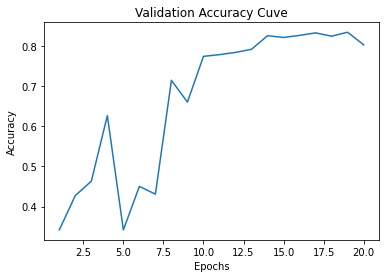

In [57]:
plt.plot(epochs, valid_accs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Cuve")

In [59]:
pd.DataFrame(results)

,dummy,Logistic Regression
fit_time,0.006146,2.715815
score_time,0.002984,0.088651
test_accuracy,0.245202,0.817417
train_accuracy,0.240482,0.951031


> We see that on average with each additional epoch, the train and validation accuracies are improving. Comparing the above accuracy curves to the baseline models from exercise 1, we see that for each epoch, the gap between the validation scores and the training scores are much smaller, indicating less overfitting by the LTSM model. Naturally it performed better than the dummy classifier. The logistic regression model seems to do the most overfitting.

### 4.4 Evaluation on the test data 

1. Get test accuracy with the final model. 
2. Compare results with train and validation accuracies. Do you see overfitting? In our previous machine learning courses we usually used cross-validation. What might be the reason of using a single validation set here?  

In [60]:
evaluate(test_iter)

0.7968860580325549

> There seems to be a little bit of overfitting here as the training accuracy of around 0.89 is larger than the test accuracy of 0.79, though both scores are fairly comparable. The use of a single validation set here is due to avoid overfitting which would occur with multiple splits. 

### 4.5 Evaluation on unseen examples

The code below loads one of the saved models. Let's try it out on unseen examples.  

We shall examine predictions given by the model on `test_sents` below.


In [61]:
# load weights
model2 = LSTMModel(EMBEDDING_SIZE, VOCAB_SIZE, NUM_CLASSES, HIDDEN_SIZE, NUM_LAYERS)
path = CHECKPOINT_PATH + "/model_19.pt"
checkpoint = torch.load(path)

model2.load_state_dict(checkpoint["model_state_dict"])
model2.to(device)

LSTMModel(
  (embedding): Embedding(3464, 100)
  (lstm_rnn): LSTM(100, 128, num_layers=2)
  (activation_fn): ReLU()
  (linear_layer): Linear(in_features=128, out_features=7, bias=True)
  (softmax_layer): LogSoftmax(dim=-1)
)

In [62]:
label_dict = [tup[0] for tup in LABEL.vocab.freqs.most_common()]
label_dict

['affection',
 'achievement',
 'bonding',
 'enjoy_the_moment',
 'leisure',
 'nature',
 'exercise']

In [63]:
topic_labels = {0: 'affection',
                1:'achievement',
                2:'bonding',
                3:'enjoy_the_moment',
                4:'leisure',
                5:'nature',
                6:'exercise'}

In [67]:
results = {}

In [68]:
def predict(model, text):
    """
    Given model and text, return predicted label for the happy moment text.
    """
    for sent in test_sents:
        atensor =  TEXT.process([TEXT.preprocess(sent)])
        atensor = atensor.to(device)
        pred = model(atensor)
        max_prob = torch.argmax(pred)
        make_me = max_prob.tolist()
        results[sent] = make_me 
        
    tmp = pd.DataFrame.from_dict(results, orient='index', columns=['Predicted Label'])
    tmp['Prediction'] = tmp['Predicted Label'].map(topic_labels)
    return tmp

In [65]:
test_sents = [
    "I just finished my last assignment!",
    "On the weekend, I spent some quality time with my best friend.",
    "I told my students that I love them all.",
    "I went for a hike in the forest.",
    "I did yoga this morning.",
    "I am still breathing and I am alive!",
]
pred_df = pd.DataFrame(test_sents, columns=["Moment"])
pred_df

,Moment
0,I just finished my last assignment!
1,"On the weekend, I spent some quality time with my best friend."
2,I told my students that I love them all.
3,I went for a hike in the forest.
4,I did yoga this morning.
5,I am still breathing and I am alive!


In [70]:
predict(model2, test_sents)

,Predicted Label,Prediction
I just finished my last assignment!,1,achievement
"On the weekend, I spent some quality time with my best friend.",2,bonding
I told my students that I love them all.,2,bonding
I went for a hike in the forest.,5,nature
I did yoga this morning.,6,exercise
I am still breathing and I am alive!,1,achievement


<br><br>

> The predictions made by the LSTM model seem to be reasonable. All the labels make sense! For instance, the label *bonding* is assigned to the text describing bonding time between friends. However, 3 out of the 6 sentences were assigned the label *achievement*. Further investigating those sentences, we see that perhaps the one about yoga could be labeled *exercise*. 

<br><br><br><br>

<br><br><br><br>